In [1]:
# !pip install --upgrade --user xgboost lightgbm tensorflow tensorflow_addons category_encoders pandas==2.0 matplotlib 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, joblib
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import xgboost as xgb
# from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import probplot
from sklearn.feature_selection import SelectKBest, SelectFromModel, SelectPercentile, f_regression, r_regression, RFE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow_addons.metrics import RSquare

plt.rcParams['figure.figsize'] = (6,4) # Overwriting the default figure size

import random

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)


2023-11-13 11:09:00.662380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
xgb.__version__

'2.0.1'

## Data processing

- The Purchase column is slightly right skewed. It will be corrected by squareroot transformation
- Some of the models requries the target values to be within [0, 10]. Therefore the squaredroot transformed purchase will be minus 3.464 then divide by 15 to transform into the desired range
- Although most data features appear to numerical, they are categorical by their nature. Considering User_ID and Product_ID are high dimensional and may contains valuable information, all the eleven data features will be casted into categories and target-encoded. 

In [4]:
%%bigquery df_blackfriday_data
select * from `blackfridayintelia.blackfriday.blackfriday`

In [5]:
# %store -r df_blackfriday_data df_blackfriday_test_data

In [6]:
df_blackfriday_data['User_ID'] = df_blackfriday_data['User_ID'].astype(str)
df_blackfriday_data['Occupation'] = df_blackfriday_data['Occupation'].astype(str)
df_blackfriday_data['Marital_Status'] = df_blackfriday_data['Marital_Status'].astype(str)
df_blackfriday_data['Product_Category_1'] = df_blackfriday_data['Product_Category_1'].astype(str)
df_blackfriday_data['Product_Category_2'] = df_blackfriday_data['Product_Category_2'].astype(str)
df_blackfriday_data['Product_Category_3'] = df_blackfriday_data['Product_Category_3'].astype(str)

In [7]:
df_blackfriday_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  object
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  object
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  object
 8   Product_Category_1          550068 non-null  object
 9   Product_Category_2          550068 non-null  object
 10  Product_Category_3          550068 non-null  object
 11  Purchase                    550068 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 50.4+ MB


In [8]:
df_blackfriday_data['Purchase'] = (df_blackfriday_data['Purchase'].pow(1/2)-3.464)/15

In [9]:
df_blackfriday_data

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,nan,nan,5.868247
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,7.988285
2,1000001,P00087842,F,0-17,10,A,2,0,12,nan,nan,2.283028
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,nan,1.936502
4,1000002,P00285442,M,55+,16,C,4+,0,8,nan,nan,5.720350
...,...,...,...,...,...,...,...,...,...,...,...,...
550063,1006033,P00372445,M,51-55,13,B,1,1,20,nan,nan,1.047955
550064,1006035,P00375436,F,26-35,1,C,3,0,20,nan,nan,1.053157
550065,1006036,P00375436,F,26-35,15,B,4+,1,20,nan,nan,0.549380
550066,1006038,P00375436,F,55+,1,C,2,0,20,nan,nan,1.042732


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_blackfriday_data.drop('Purchase', axis=1), df_blackfriday_data['Purchase'], random_state=random_seed, test_size=0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(412551, 11) (412551,)
(137517, 11) (137517,)


In [11]:
from category_encoders import TargetEncoder

encoder = TargetEncoder()

enc = encoder.fit(X=X_train, y=y_train)

df_train_X = enc.transform(X_train)
df_test_X = enc.transform(X_test)

# df_train_X['y'] = y_train
# df_train_X

## Linear Model

In [12]:
regressor  = LinearRegression()
regressor.fit(df_train_X,y_train)

y_pred = regressor.predict(df_test_X)

In [13]:
from math import sqrt
print('Scaled RMSE:', sqrt(mean_squared_error(y_test, y_pred)))
print("RMSE on the original test data is ",sqrt(mean_squared_error((y_test*15 + 3.464)*(y_test*15 + 3.464), (y_pred*15 + 3.464)*(y_pred*15 + 3.464))))

Scaled RMSE: 0.9198663268353303
RMSE on the original test data is  2616.659619478716


<Axes: title={'center': 'Model Coefficients'}>

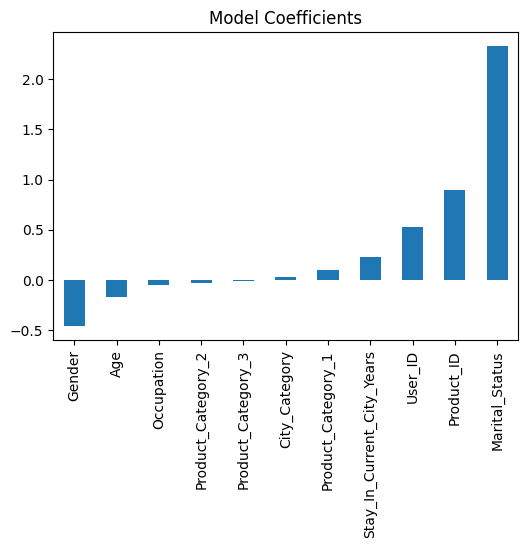

In [14]:
coef = pd.Series(regressor.coef_, df_train_X.columns).sort_values()
coef.plot(kind='bar', title='Model Coefficients')

## XGBoosting

In [15]:
xgb_reg = XGBRegressor( seed=random_seed)
xgb_reg.fit(df_train_X, y_train)
xgb_y_pred = xgb_reg.predict(df_test_X)
print('Scaled RMSE:', sqrt(mean_squared_error(y_test, xgb_y_pred)))
print("RMSE on the original test data is ",sqrt(mean_squared_error((y_test*15 + 3.464)*(y_test*15 + 3.464), (xgb_y_pred*15 + 3.464)*(xgb_y_pred*15 + 3.464))))

Scaled RMSE: 0.8900746838357412
RMSE on the original test data is  2540.2624835366787


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

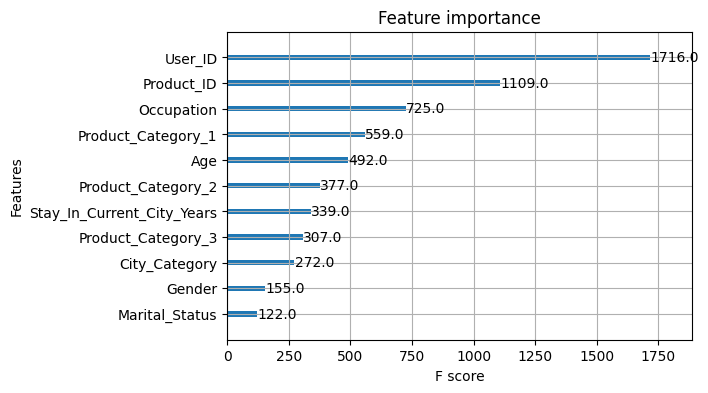

In [16]:
xgb.plot_importance(xgb_reg)

## LightGBM

In [17]:
lgb_reg = LGBMRegressor( seed=random_seed)
lgb_reg.fit(df_train_X, y_train)
lgb_y_pred = lgb_reg.predict(df_test_X)
print('Scaled RMSE:', sqrt(mean_squared_error(y_test, lgb_y_pred)))
print("RMSE on the original test data is ",sqrt(mean_squared_error((y_test*15 + 3.464)*(y_test*15 + 3.464), (lgb_y_pred*15 + 3.464)*(lgb_y_pred*15 + 3.464))))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 412551, number of used features: 11
[LightGBM] [Info] Start training from score 5.923576
Scaled RMSE: 0.9003429519047392
RMSE on the original test data is  2570.06429018307


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

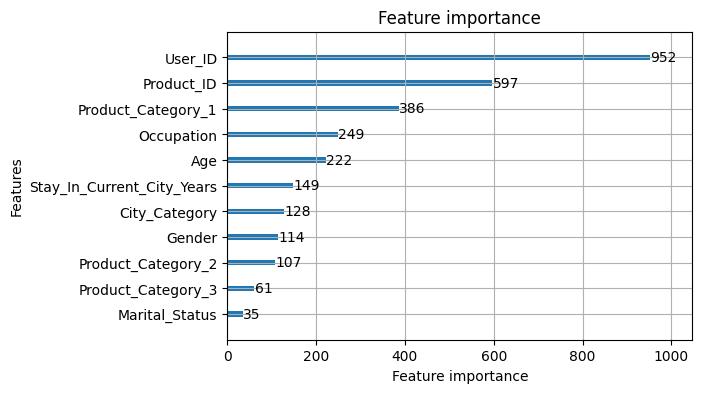

In [18]:
lgb.plot_importance(lgb_reg)

## Bare User and Product

In [19]:
df_train_X_fair = df_train_X[['User_ID','Product_ID']]
df_test_X_fair = df_test_X[['User_ID','Product_ID']]
xgb_reg = XGBRegressor( seed=random_seed)
xgb_reg.fit(df_train_X_fair, y_train)
xgb_y_bare = xgb_reg.predict(df_test_X_fair)
print('Scaled RMSE:', sqrt(mean_squared_error(y_test, xgb_y_bare)))
print("RMSE on the original test data is ",sqrt(mean_squared_error((y_test*15 + 3.464)*(y_test*15 + 3.464), (xgb_y_bare*15 + 3.464)*(xgb_y_bare*15 + 3.464))))

Scaled RMSE: 0.9170104653523904
RMSE on the original test data is  2611.7739705491117


## Fairness Analysis

In [20]:
df_train_X_fair = df_train_X[['User_ID','Product_ID', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']]
df_test_X_fair = df_test_X[['User_ID','Product_ID', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']]

In [21]:
xgb_reg = XGBRegressor( seed=random_seed)
xgb_reg.fit(df_train_X_fair, y_train)
xgb_y_fair = xgb_reg.predict(df_test_X_fair)
print('Scaled RMSE:', sqrt(mean_squared_error(y_test, xgb_y_fair)))
print("RMSE on the original test data is ",sqrt(mean_squared_error((y_test*15 + 3.464)*(y_test*15 + 3.464), (xgb_y_fair*15 + 3.464)*(xgb_y_fair*15 + 3.464))))

Scaled RMSE: 0.9058408675493015
RMSE on the original test data is  2587.4250267027105


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

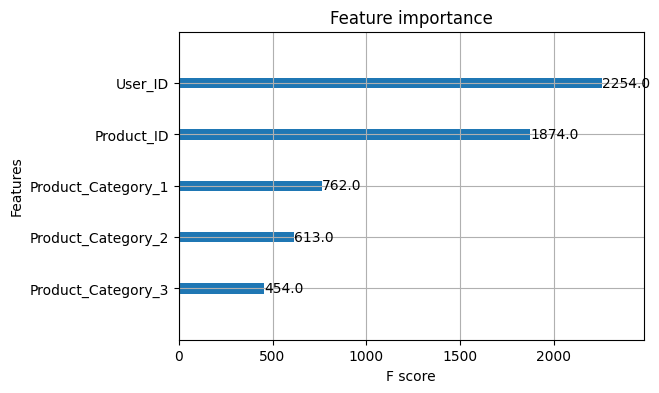

In [22]:
xgb.plot_importance(xgb_reg)

In [23]:
df_fair = X_test.copy()
df_fair['y'] = (y_test*15 + 3.464)*(y_test*15 + 3.464)
df_fair['y_pred'] = (xgb_y_pred*15 + 3.464)*(xgb_y_pred*15 + 3.464)
df_fair['y_fair'] = (xgb_y_fair*15 + 3.464)*(xgb_y_fair*15 + 3.464)  

In [24]:
df_fair

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,y,y_pred,y_fair
84432,1001062,P00351342,M,51-55,19,C,3,0,1,2.0,16.0,19142.0,13663.523438,13337.349609
72724,1005172,P00237542,F,36-45,11,B,1,0,1,15.0,16.0,15513.0,15442.254883,16342.949219
197032,1000415,P00116242,F,36-45,0,A,2,1,8,15.0,nan,7802.0,7973.280762,7778.169434
353704,1000496,P00016742,M,18-25,4,A,3,0,1,15.0,16.0,15455.0,12413.919922,12068.192383
91198,1002010,P00002242,M,18-25,4,B,0,0,6,8.0,16.0,4492.0,10355.034180,10698.931641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288415,1002411,P00346442,F,36-45,14,B,1,0,1,2.0,14.0,7820.0,10751.178711,10189.870117
204984,1001631,P00084542,F,51-55,0,C,4+,0,5,nan,nan,8821.0,7121.016602,6365.272949
135828,1002994,P00192942,M,36-45,5,A,1,1,5,nan,nan,7016.0,6719.999023,6885.555664
243905,1001595,P00124542,M,36-45,1,C,3,0,11,nan,nan,4623.0,4229.905762,4101.028809


<Axes: ylabel='Frequency'>

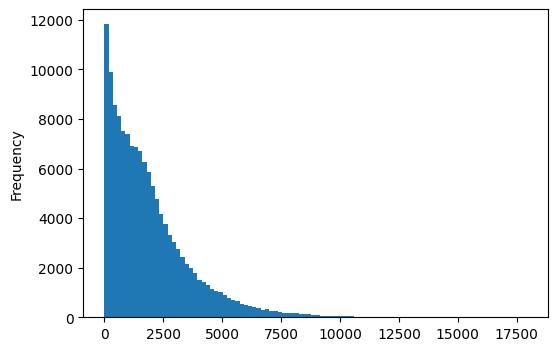

In [25]:
df_fair['y_fair_rmse'] = ((df_fair['y_fair'] - df_fair['y'])*(df_fair['y_fair'] - df_fair['y'])).pow(1/2)
df_fair['y_pred_rmse'] = ((df_fair['y_pred'] - df_fair['y'])*(df_fair['y_pred'] - df_fair['y'])).pow(1/2)

df_fair['y_fair_rmse'].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

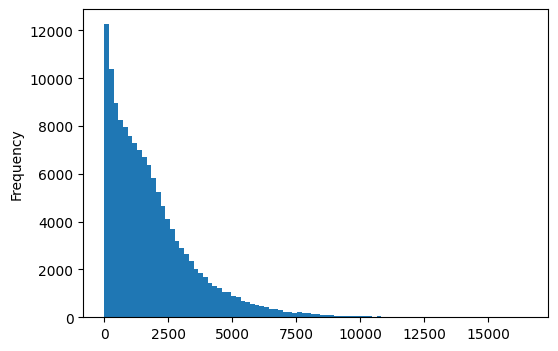

In [26]:
df_fair['y_pred_rmse'].plot.hist(bins=90)

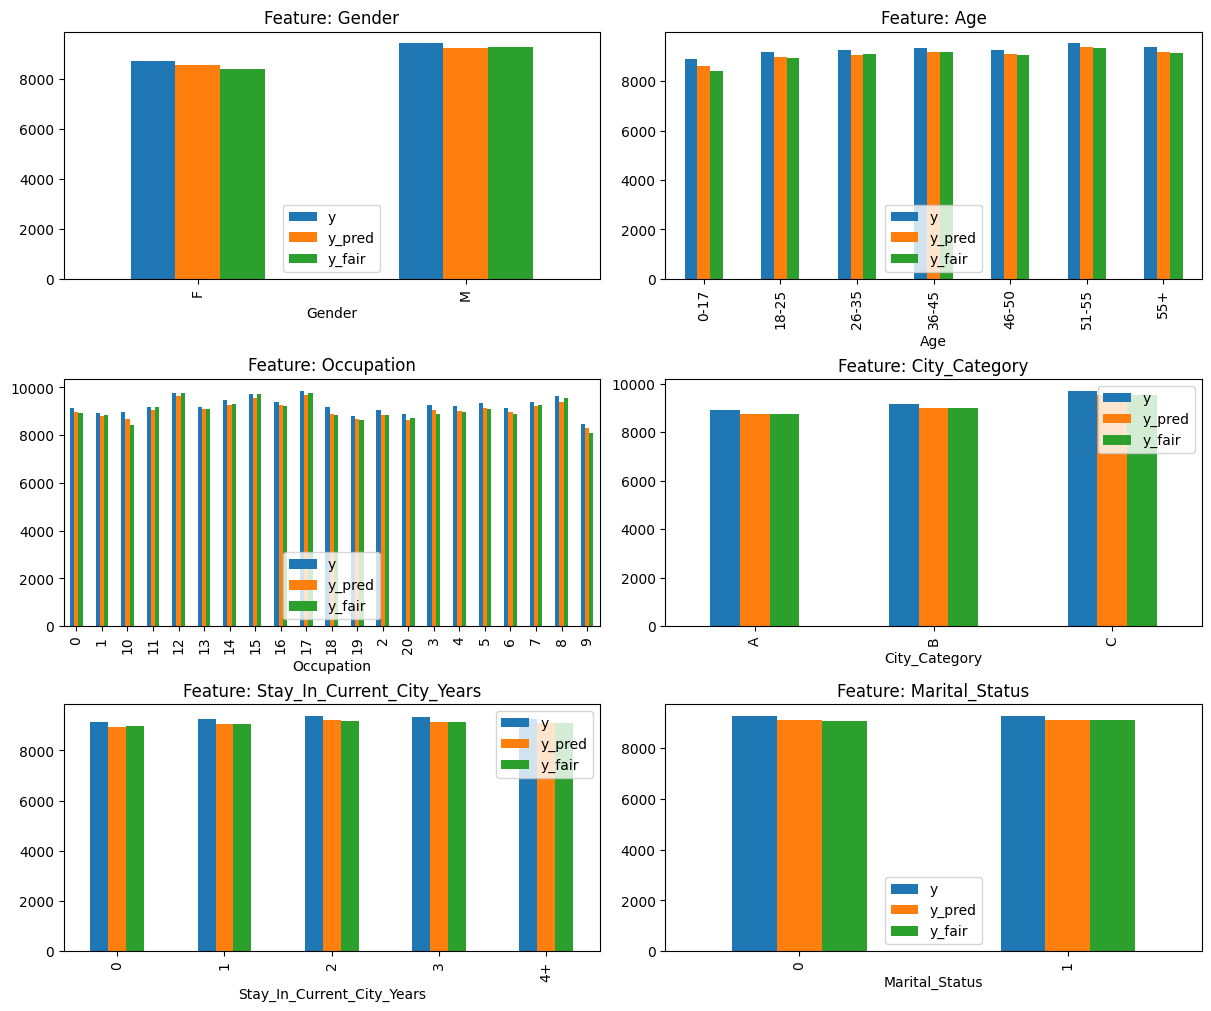

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10), constrained_layout = True)


for i,f in enumerate(['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']):
    df_fair.groupby(f)[['y','y_pred', 'y_fair']].mean().plot(ax=axes[i//2, i%2] ,kind='bar', title=f'Feature: {f}')

## Residual Analysis

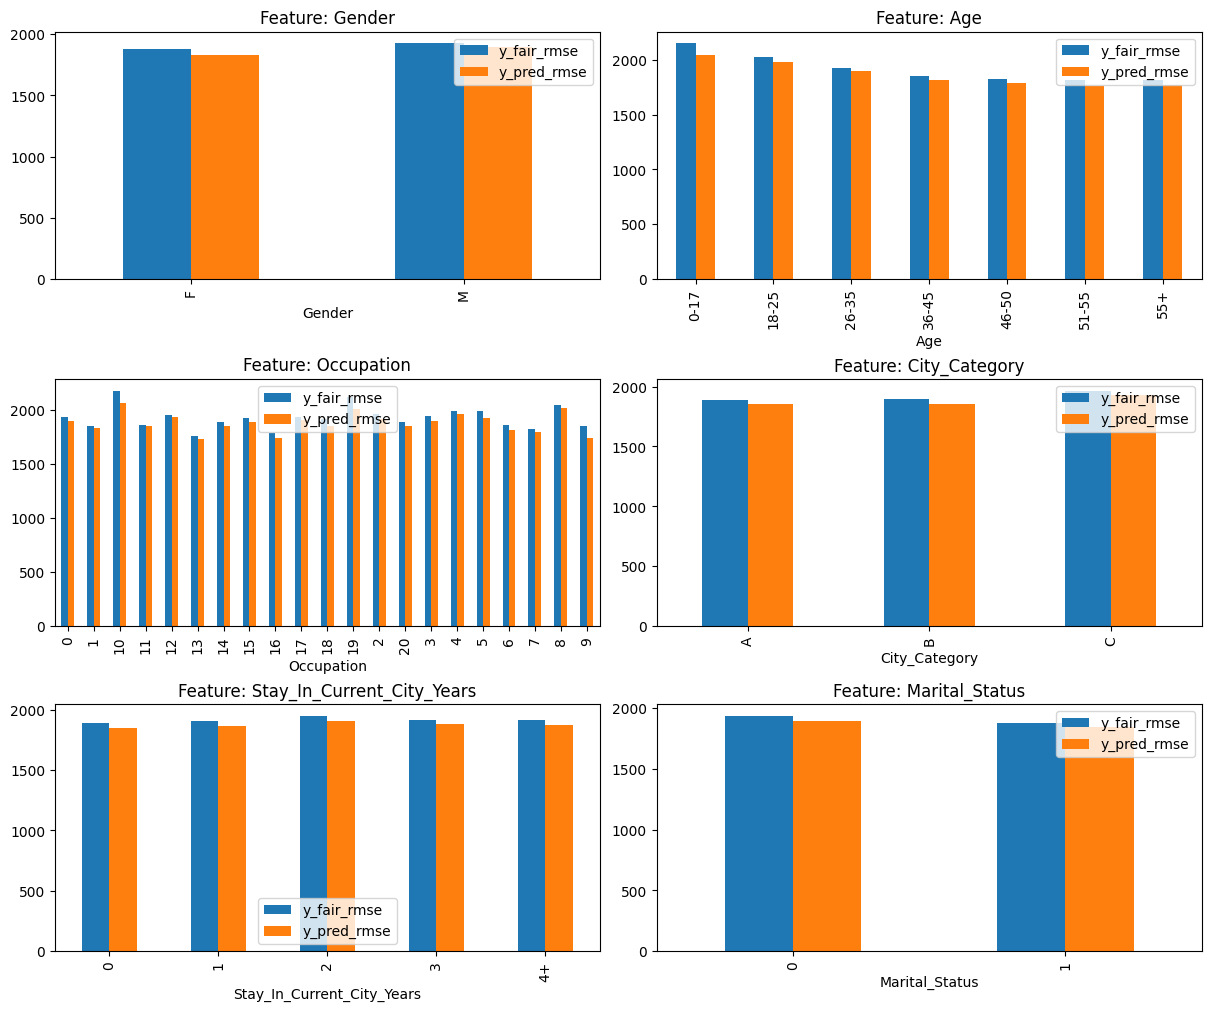

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10), constrained_layout = True)


for i,f in enumerate(['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']):
    df_fair.groupby(f)[['y_fair_rmse', 'y_pred_rmse']].mean().plot(ax=axes[i//2, i%2] ,kind='bar', title=f'Feature: {f}')

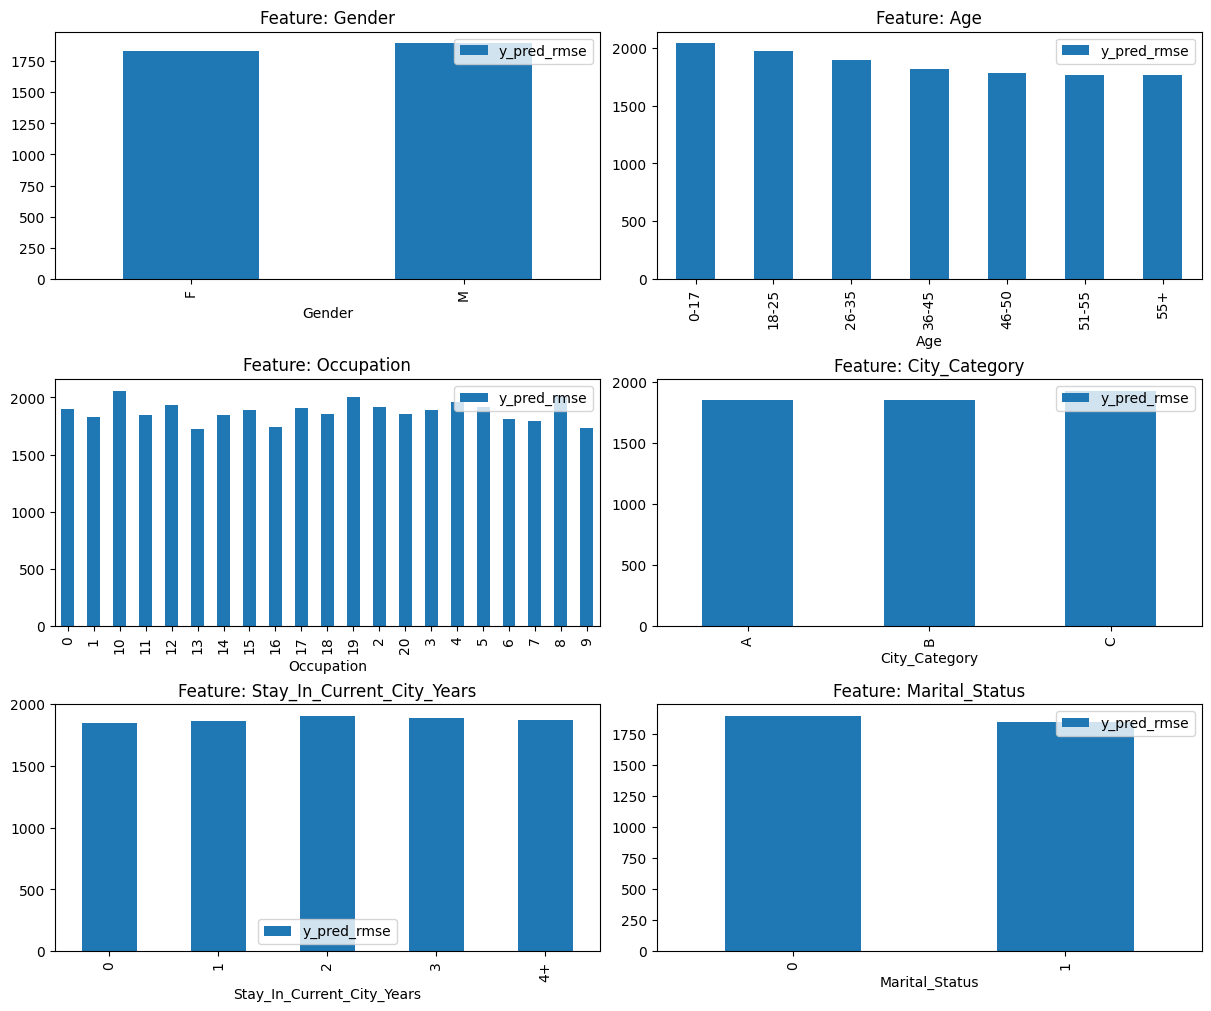

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10), constrained_layout = True)


for i,f in enumerate(['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']):
    df_fair.groupby(f)[['y_pred_rmse']].mean().plot(ax=axes[i//2, i%2] ,kind='bar', title=f'Feature: {f}')

<Axes: title={'center': 'Regression - XGBoost: prediction vs target'}, xlabel='y', ylabel='y_pred'>

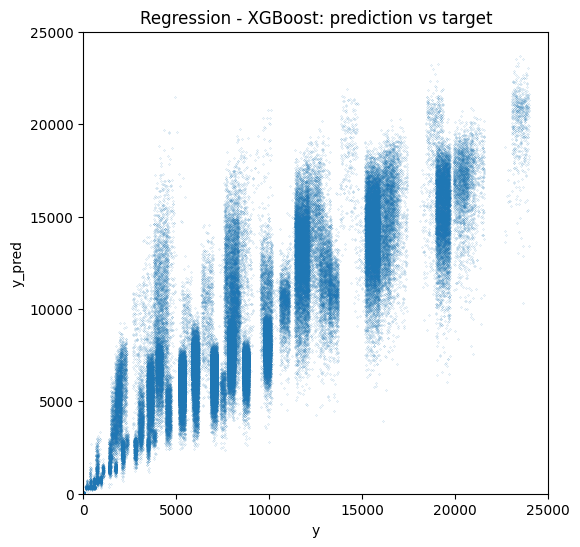

In [29]:
df_fair[['y', 'y_pred']].plot.scatter(x='y', 
                                      y='y_pred', 
                                      xlim=[0,25000], 
                                      ylim=[0,25000], 
                                      s=0.01, 
                                      title='Regression - XGBoost: prediction vs target',
                                      figsize=(6,6))

<Axes: title={'center': 'Regression - XGBoost: Fair vs Target'}, xlabel='y', ylabel='y_fair'>

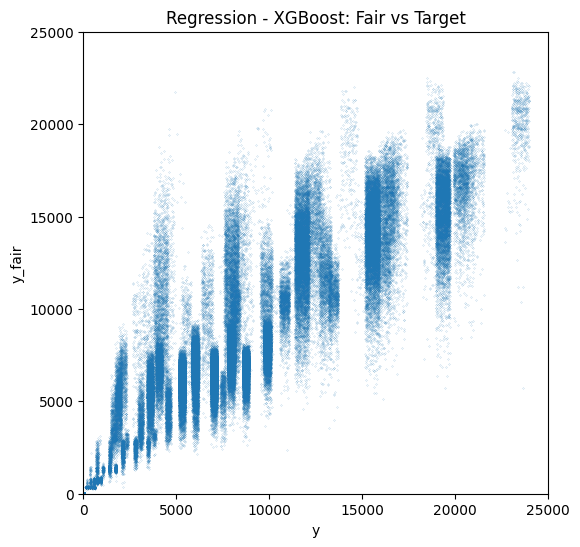

In [30]:
df_fair[['y', 'y_fair']].plot.scatter(x='y', 
                                      y='y_fair', 
                                      xlim=[0,25000], 
                                      ylim=[0,25000], 
                                      s=0.01, 
                                      title='Regression - XGBoost: Fair vs Target',
                                      figsize=(6,6))

<Axes: title={'center': 'Fair RMSE vs Full-featured RMSE'}, xlabel='y_fair_rmse', ylabel='y_pred_rmse'>

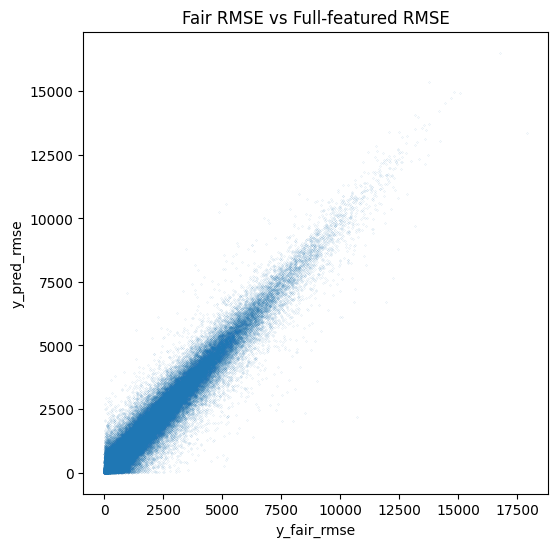

In [31]:
df_fair[['y_fair_rmse', 'y_pred_rmse']].plot.scatter(x='y_fair_rmse', 
                                                     y='y_pred_rmse', 
                                                     s=0.003,
                                                     title='Fair RMSE vs Full-featured RMSE',
                                                     figsize=(6,6))

<Axes: title={'center': 'Regression - XGBoost: sqrt(prediction) vs sqrt(target)'}, xlabel='y_r', ylabel='y_pred_r'>

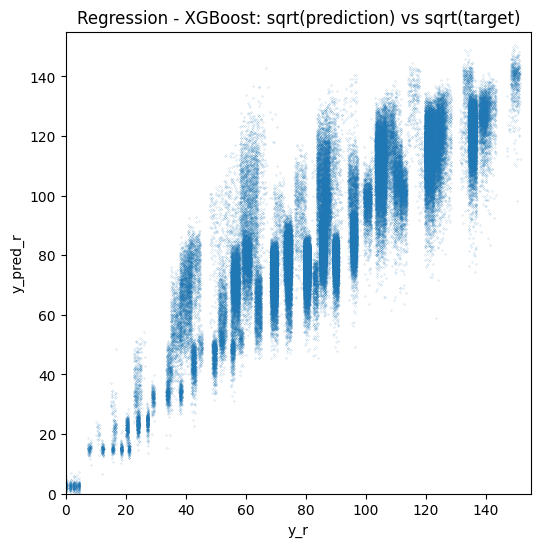

In [32]:
df_fair['y_r'] = df_fair['y'].pow(1/2)-3.464
df_fair['y_pred_r'] = df_fair['y_pred'].pow(1/2)-3.464
df_fair[['y_r', 'y_pred_r']].plot.scatter(x='y_r', 
                                          y='y_pred_r', 
                                          s=0.01, 
                                          xlim=[0,155], 
                                          ylim=[0,155], 
                                          title='Regression - XGBoost: sqrt(prediction) vs sqrt(target)',
                                          figsize=(6, 6))